

<h3 style="text-align:center; background-color:#C8FF33;padding:40px;border-radius: 30px;">
<p style="text-align: left">See also this notebook:</p>
    <p style="text-align: left"><b><a href="https://www.kaggle.com/code/soumya9977/hubmap-multiorgan-segmentation-1-3-data-prep"> &nbsp; HuBMAP multiOrgan Segmentation 1/3 [data prep]</a></b></p>
    <p style="text-align: left"><b>* HuBMAP: Vanilla Unet + W&B + Pytorch 2/3 [train]</b></p>
    <p style="text-align: left"><b><a href="https://www.kaggle.com/code/soumya9977/hubmap-vanilla-unet-pytorch-3-3-inference"> &nbsp; HuBMAP: Vanilla Unet Pytorch 3/3 [inference]</a></b></p>
</h3>


## Please _DO_ upvote!


### Changelog

|| Version | Comments | LB |
|---|  --- | --- | --- |
|**Best**| -- | effNetUnet w/ 256x256, 50 epoch, no aug, Warmup CosineAnnealingLR lr sch, no pre/post processing, L2 norm, bs=8 | `--` |

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-g14vza1b
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-g14vza1b
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit c98c88d13481c956b232dec6fc13609859838d7a
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 708.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.7 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0-py3-none-any.whl size=97946 sha256=9bfa3cbd92162d015430aac7501d2442ed1bbf538c07ca36c1d1af3eb54b95be
  Stored in directory: /tmp/pip-ephem-whe

In [2]:
# !pip install -q tifffile

# Import, SEED, Config:

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
import cv2
import matplotlib.pyplot as plt
import json
import gc
import time
from tqdm import tqdm
import random
from collections import defaultdict
from IPython.display import display

#Pytorch Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.optim import lr_scheduler
# from tifffile import imread
import segmentation_models_pytorch as smp
import transformers
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from sklearn.model_selection import train_test_split

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL
b_ = Fore.BLUE

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

warnings.filterwarnings("ignore")

In [4]:
# Hyperparameters etc.
# Hyperparameters
CONFIG = {
    "in_channels" :3,
    "num_classes": 1,
    "BATCH_SIZE" : 8,
    "NUM_EPOCHS" : 50,
    "n_accumulate": 1,
    "competition": "HuBMAP-Kaggle", # HuBMAP-Kaggle
    "model_name": "Vanilla_Unet",
    "LEARNING_RATE": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", 
    "AUG": "No",
    "SEED": 42,
    "opt": 'Adam',
    "Normalization": "L2",
    "img_size": 256,
    "scheduler": "CosineAnnealingWarmRestarts",#'CosineAnnealingLR',
    "warmup_epochs": 2,
    "n_folds": 5,
    "folds_to_run": [0],
    "min_lr": 1e-6,
    "T_max": 500, 
    "T_0": 20
}

In [5]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CONFIG["SEED"])

> SEEDING DONE


# WandB:

In [6]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')
# wandb.init(project="PogChamp2 Baseline")
run = wandb.init(project=CONFIG['competition'], 
                 config=CONFIG,
                 job_type='Train',
                 tags=['semantic segmentation', CONFIG['model_name']],
                 anonymous='must',
                 name = "Vanilla_Unet_1",
                 notes = "")

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Tabular:

In [7]:
# !ls ../input/hubmap-tiled-data-generation/tiled_data
DATA_DIR = "../input/hubmap-tiled-data-generation/tiled_data/"

img_list = [os .path.join(DATA_DIR+'images',i) for i in os.listdir(DATA_DIR+"images")]
mask_list = [os .path.join(DATA_DIR+'masks',i) for i in os.listdir(DATA_DIR+"masks")]

data_dict = {
    "img_path": img_list,
    "mask_path": mask_list
}

train_df = pd.DataFrame.from_dict(data_dict)
display(train_df)
# plt.imshow(plt.imread(mask_list[3]))
# img_list[0:5],mask_list[0:5]

,img_path,mask_path
0,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
1,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
2,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
3,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
4,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
...,...,...
3154,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
3155,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
3156,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...
3157,../input/hubmap-tiled-data-generation/tiled_da...,../input/hubmap-tiled-data-generation/tiled_da...


In [8]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=CONFIG["SEED"])

train_df.__len__(), len(test_df)

(2527, 632)

In [9]:
# %timeit img_temp = plt.imread(train_df["mask_path"].iloc[0])

# Pytorch Data Class:

In [10]:
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])


def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))



class hubmap_data(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.img_paths = df["img_path"].to_numpy()
        self.mask_paths = df["mask_path"].to_numpy()
        self.transform = transform
        
        
    def __getitem__(self, index):
        # load data from the pre-processed npy files
        img_file = self.img_paths[index]
#         print(img_file)
        mask_file = self.mask_paths[index]
        img = plt.imread(img_file)#cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
#         img = imread(img_file) #np.moveaxis(imread(img_file), -1, 0) #torch.from_numpy(np.moveaxis(imread(img_file), -1, 0))
        # semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
#         mask = torch.from_numpy(np.moveaxis(np.load(mask_file), -1, 0))
        mask = plt.imread(mask_file) #np.moveaxis(np.load(mask_file), -1, 0) #torch.from_numpy(np.moveaxis(np.load(mask_file), -1, 0))
        
        
#       print(depth.shape)
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]

            if mask.shape[-1] == 1:
                mask = mask.permute(2,0,1)
                
                
        return  img2tensor(img),img2tensor(mask)

    def __len__(self):
        return len(self.df)

In [11]:
train_transform = A.Compose(
    [
        A.Resize(256, 256, p=1.0),
#         A.HorizontalFlip(p=1.0),
#         A.RandomCrop(224, 224, p=0.3),
#         A.RandomSizedCrop(cfg["min_max_height"], cfg["height"], cfg["width"], cfg["w2h_ratio"], cfg["interpolation"], p=1), 
#         ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(256, 256, p=1.0),
        ToTensorV2(),
    ]
)

In [12]:
train_data = hubmap_data(train_df,train_transform)
test_data = hubmap_data(test_df, train_transform) # CHANGED [change the augmentation method]

print(train_data[10][0].shape, train_data[10][1].shape)
# test_data[10][0].shape, test_data[10][1].shape

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


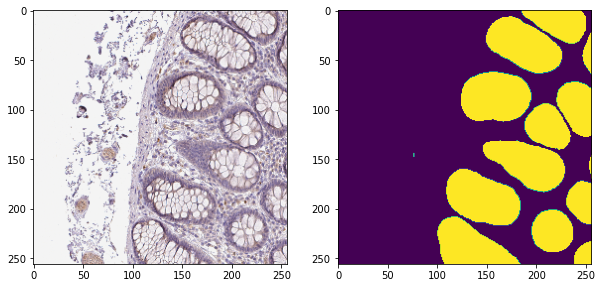

In [13]:
temp_img = train_data[50][0]
temp_mask = train_data[50][1]
# plt.imshow(temp_mask.detach().numpy())
# plt.imshow(temp_img.permute(1,2,0).detach().numpy())


img_trfm = (temp_img.permute(1,2,0)).detach().numpy()
mask_trfm = (temp_mask.permute(1,2,0)).detach().numpy()

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(img_trfm)


plt.subplot(1,2,2)
plt.imshow(mask_trfm)

# temp_img.permute(1,2,0).detach().numpy()

# Unet Model:

In [14]:
def init_model():
    model =  smp.Unet(
                 encoder_name='efficientnet-b4',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=1)
    return model

# Model check:

In [15]:
train_on_gpu = torch.cuda.is_available()
model = init_model() #UNet(n_channels=CONFIG["in_channels"], n_classes=CONFIG["num_classes"])
if train_on_gpu:
    model.cuda()

model(temp_img.unsqueeze(0).cuda()).shape

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

torch.Size([1, 1, 256, 256])

# DataLoader

In [16]:
# REMARK shuffle = False [result might change with shuffle =True]
train_loader = torch.utils.data.DataLoader(
               dataset=train_data,
               batch_size=CONFIG["BATCH_SIZE"],
               shuffle=False,
               num_workers=2)

test_loader = torch.utils.data.DataLoader(
              dataset=test_data,
              batch_size=CONFIG["BATCH_SIZE"],
              shuffle=False,
              num_workers=2)

In [17]:
def get_scheduler(optimizer):
    num_steps = 12
    
#     if len(train_df[train_df['fold'] == CONFIG["folds_to_run"][0]]) % CONFIG["BATCH_SIZE"] != 0:
#         num_steps = len(train_df[train_df['fold'] != CONFIG["folds_to_run"][0]]) // CONFIG["BATCH_SIZE"] + 1
    
#     else:
#         len(train_df[train_df['fold'] != CONFIG["folds_to_run"][0]]) // CONFIG["BATCH_SIZE"]
    
    if CONFIG["scheduler"] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
#         scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, CONFIG["warmup_epochs"] * num_steps, CONFIG["NUM_EPOCHS"] * num_steps)
        
    elif CONFIG["scheduler"] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, threshold=0.0001, min_lr=1e-6)
    elif CONFIG["scheduler"] == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
        
    return scheduler

# Loss, Optimizer & Metric:

In [18]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

loss_fn = DiceLoss() #Dice()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["LEARNING_RATE"],weight_decay=1e-5)

In [19]:
class DiceCoef(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, y_pred, y_true, smooth=1.):
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        
        #Round off y_pred
        y_pred = torch.round((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))
        
        intersection = (y_true * y_pred).sum()
        dice = (2.0*intersection + smooth)/(y_true.sum() + y_pred.sum() + smooth)
        
        return dice

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

dice_coe = DiceCoef()

# model save class:

In [20]:
model_path = "./model_weights"
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
def save_model(model, optimizer, criterion, epoch):
    """
    Function to save the trained model to disk.
    """
    print(f"\n Saving model at {epoch}th epoch")
    fname = f'{model_path}/{CONFIG["model_name"]}-{CONFIG["LEARNING_RATE"]}-{CONFIG["AUG"]}-{epoch}-{CONFIG["BATCH_SIZE"]}.pth'
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, fname )
    return fname

## Train & Validation Function:

In [21]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter#Training-Function
def train_fn(loader, model, optimizer, loss_fn,epoch, scheduler):
    bar = tqdm(enumerate(loader), total=len(loader))
    
    
    running_loss = 0.0
    dataset_size = 0
    
    for batch_idx, (data, targets) in bar:
        data = data.to(device=CONFIG["DEVICE"])
        targets = targets.float().to(device=CONFIG["DEVICE"])

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets)

        
        optimizer.zero_grad()
        # backward
        loss.backward()
        # Update Weights
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
            
        # Calculate Loss
        running_loss += loss.item()
        
        epoch_loss = running_loss / len(loader)
#         running_loss += (loss.item() * BATCH_SIZE)
#         dataset_size += BATCH_SIZE
        
#         epoch_loss = running_loss / dataset_size
        # update tqdm loop
        bar.set_postfix(Epoch=epoch,loss=epoch_loss)
    
        
    gc.collect()
    
    return epoch_loss

In [22]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
#     criterion = losses[CFG.loss]
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, masks) in pbar:
        images  = images.to(CONFIG["DEVICE"], dtype=torch.float)
        masks   = masks.to(CONFIG["DEVICE"], dtype=torch.float)
        
        
        y_pred  = model(images)
        loss    = loss_fn(y_pred, masks)
        
        running_loss += (loss.item() * CONFIG["BATCH_SIZE"])
        dataset_size += CONFIG["BATCH_SIZE"]
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# Train loop:

===================== Epoch: [1/50] =====================


100%|██████████| 79/79 [00:31<00:00,  2.50it/s, gpu_memory=3.46 GB, lr=0.00001, valid_loss=0.9940]



 Saving model at 1th epoch

 Final Train Loss: 0.9960  |  Final Val Loss: 0.9940
Valid Dice: 0.0077 | Valid Jaccard: 0.0047
val dice increased: -inf ---> 0.007696707732975483
val jaccard increased: -inf ---> 0.004683232866227627
===================== Epoch: [2/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.87it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9683]



 Saving model at 2th epoch

 Final Train Loss: 0.9752  |  Final Val Loss: 0.9683
Valid Dice: 0.3650 | Valid Jaccard: 0.3630
val dice increased: 0.007696707732975483 ---> 0.3649623394012451
val jaccard increased: 0.004683232866227627 ---> 0.36303573846817017
===================== Epoch: [3/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.88it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9632]



 Saving model at 3th epoch

 Final Train Loss: 0.9723  |  Final Val Loss: 0.9632
Valid Dice: 0.3632 | Valid Jaccard: 0.3598
===================== Epoch: [4/50] =====================


100%|██████████| 79/79 [00:26<00:00,  2.94it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9614]



 Saving model at 4th epoch

 Final Train Loss: 0.9704  |  Final Val Loss: 0.9614
Valid Dice: 0.3648 | Valid Jaccard: 0.3614
===================== Epoch: [5/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.84it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9603]



 Saving model at 5th epoch

 Final Train Loss: 0.9692  |  Final Val Loss: 0.9603
Valid Dice: 0.3662 | Valid Jaccard: 0.3629
val dice increased: 0.3649623394012451 ---> 0.36624065041542053
===================== Epoch: [6/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.85it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9608]



 Saving model at 6th epoch

 Final Train Loss: 0.9694  |  Final Val Loss: 0.9608
Valid Dice: 0.3663 | Valid Jaccard: 0.3637
val dice increased: 0.36624065041542053 ---> 0.36628302931785583
val jaccard increased: 0.36303573846817017 ---> 0.36370667815208435
===================== Epoch: [7/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.85it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9592]



 Saving model at 7th epoch

 Final Train Loss: 0.9690  |  Final Val Loss: 0.9592
Valid Dice: 0.3632 | Valid Jaccard: 0.3598
===================== Epoch: [8/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.82it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9612]



 Saving model at 8th epoch

 Final Train Loss: 0.9690  |  Final Val Loss: 0.9612
Valid Dice: 0.3624 | Valid Jaccard: 0.3594
===================== Epoch: [9/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.89it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9582]



 Saving model at 9th epoch

 Final Train Loss: 0.9694  |  Final Val Loss: 0.9582
Valid Dice: 0.3665 | Valid Jaccard: 0.3630
val dice increased: 0.36628302931785583 ---> 0.3664814829826355
===================== Epoch: [10/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.81it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9582]



 Saving model at 10th epoch

 Final Train Loss: 0.9687  |  Final Val Loss: 0.9582
Valid Dice: 0.3665 | Valid Jaccard: 0.3630
val dice increased: 0.3664814829826355 ---> 0.3664844036102295
===================== Epoch: [11/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.79it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9586]



 Saving model at 11th epoch

 Final Train Loss: 0.9687  |  Final Val Loss: 0.9586
Valid Dice: 0.3678 | Valid Jaccard: 0.3645
val dice increased: 0.3664844036102295 ---> 0.3677801191806793
val jaccard increased: 0.36370667815208435 ---> 0.36446693539619446
===================== Epoch: [12/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.85it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9707]



 Saving model at 12th epoch

 Final Train Loss: 0.9689  |  Final Val Loss: 0.9707
Valid Dice: 0.3660 | Valid Jaccard: 0.3628
===================== Epoch: [13/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.86it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9619]



 Saving model at 13th epoch

 Final Train Loss: 0.9689  |  Final Val Loss: 0.9619
Valid Dice: 0.3661 | Valid Jaccard: 0.3636
===================== Epoch: [14/50] =====================


100%|██████████| 79/79 [00:26<00:00,  2.97it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9596]



 Saving model at 14th epoch

 Final Train Loss: 0.9690  |  Final Val Loss: 0.9596
Valid Dice: 0.3661 | Valid Jaccard: 0.3628
===================== Epoch: [15/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.84it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9587]



 Saving model at 15th epoch

 Final Train Loss: 0.9697  |  Final Val Loss: 0.9587
Valid Dice: 0.3678 | Valid Jaccard: 0.3645
===================== Epoch: [16/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.79it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9587]



 Saving model at 16th epoch

 Final Train Loss: 0.9686  |  Final Val Loss: 0.9587
Valid Dice: 0.3677 | Valid Jaccard: 0.3644
===================== Epoch: [17/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.76it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9586]



 Saving model at 17th epoch

 Final Train Loss: 0.9685  |  Final Val Loss: 0.9586
Valid Dice: 0.3676 | Valid Jaccard: 0.3644
===================== Epoch: [18/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.84it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9705]



 Saving model at 18th epoch

 Final Train Loss: 0.9693  |  Final Val Loss: 0.9705
Valid Dice: 0.3521 | Valid Jaccard: 0.3487
===================== Epoch: [19/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.85it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9712]



 Saving model at 19th epoch

 Final Train Loss: 0.9702  |  Final Val Loss: 0.9712
Valid Dice: 0.3352 | Valid Jaccard: 0.3316
===================== Epoch: [20/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.78it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9589]



 Saving model at 20th epoch

 Final Train Loss: 0.9686  |  Final Val Loss: 0.9589
Valid Dice: 0.3647 | Valid Jaccard: 0.3614
===================== Epoch: [21/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.79it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9595]



 Saving model at 21th epoch

 Final Train Loss: 0.9684  |  Final Val Loss: 0.9595
Valid Dice: 0.3671 | Valid Jaccard: 0.3641
===================== Epoch: [22/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.85it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9586]



 Saving model at 22th epoch

 Final Train Loss: 0.9683  |  Final Val Loss: 0.9586
Valid Dice: 0.3675 | Valid Jaccard: 0.3643
===================== Epoch: [23/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.90it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9588]



 Saving model at 23th epoch

 Final Train Loss: 0.9682  |  Final Val Loss: 0.9588
Valid Dice: 0.3643 | Valid Jaccard: 0.3611
===================== Epoch: [24/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.83it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9592]



 Saving model at 24th epoch

 Final Train Loss: 0.9681  |  Final Val Loss: 0.9592
Valid Dice: 0.3671 | Valid Jaccard: 0.3641
===================== Epoch: [25/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.83it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9592]



 Saving model at 25th epoch

 Final Train Loss: 0.9684  |  Final Val Loss: 0.9592
Valid Dice: 0.3672 | Valid Jaccard: 0.3642
===================== Epoch: [26/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.73it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9596]



 Saving model at 26th epoch

 Final Train Loss: 0.9682  |  Final Val Loss: 0.9596
Valid Dice: 0.3668 | Valid Jaccard: 0.3640
===================== Epoch: [27/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.80it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9592]



 Saving model at 27th epoch

 Final Train Loss: 0.9681  |  Final Val Loss: 0.9592
Valid Dice: 0.3655 | Valid Jaccard: 0.3625
===================== Epoch: [28/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.81it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9586]



 Saving model at 28th epoch

 Final Train Loss: 0.9684  |  Final Val Loss: 0.9586
Valid Dice: 0.3641 | Valid Jaccard: 0.3610
===================== Epoch: [29/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.80it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9609]



 Saving model at 29th epoch

 Final Train Loss: 0.9682  |  Final Val Loss: 0.9609
Valid Dice: 0.3662 | Valid Jaccard: 0.3637
===================== Epoch: [30/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.79it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9588]



 Saving model at 30th epoch

 Final Train Loss: 0.9683  |  Final Val Loss: 0.9588
Valid Dice: 0.3671 | Valid Jaccard: 0.3641
===================== Epoch: [31/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.66it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9586]



 Saving model at 31th epoch

 Final Train Loss: 0.9682  |  Final Val Loss: 0.9586
Valid Dice: 0.3671 | Valid Jaccard: 0.3641
===================== Epoch: [32/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.76it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9582]



 Saving model at 32th epoch

 Final Train Loss: 0.9680  |  Final Val Loss: 0.9582
Valid Dice: 0.3673 | Valid Jaccard: 0.3642
===================== Epoch: [33/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.64it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9606]



 Saving model at 33th epoch

 Final Train Loss: 0.9681  |  Final Val Loss: 0.9606
Valid Dice: 0.3662 | Valid Jaccard: 0.3637
===================== Epoch: [34/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.69it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9599]



 Saving model at 34th epoch

 Final Train Loss: 0.9680  |  Final Val Loss: 0.9599
Valid Dice: 0.3668 | Valid Jaccard: 0.3640
===================== Epoch: [35/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.69it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9716]



 Saving model at 35th epoch

 Final Train Loss: 0.9682  |  Final Val Loss: 0.9716
Valid Dice: 0.3642 | Valid Jaccard: 0.3611
===================== Epoch: [36/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.84it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9789]



 Saving model at 36th epoch

 Final Train Loss: 0.9705  |  Final Val Loss: 0.9789
Valid Dice: 0.1417 | Valid Jaccard: 0.1382
===================== Epoch: [37/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.72it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9587]



 Saving model at 37th epoch

 Final Train Loss: 0.9689  |  Final Val Loss: 0.9587
Valid Dice: 0.3672 | Valid Jaccard: 0.3642
===================== Epoch: [38/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.69it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9582]



 Saving model at 38th epoch

 Final Train Loss: 0.9681  |  Final Val Loss: 0.9582
Valid Dice: 0.3644 | Valid Jaccard: 0.3612
===================== Epoch: [39/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.81it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9581]



 Saving model at 39th epoch

 Final Train Loss: 0.9680  |  Final Val Loss: 0.9581
Valid Dice: 0.3656 | Valid Jaccard: 0.3626
===================== Epoch: [40/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.73it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9587]



 Saving model at 40th epoch

 Final Train Loss: 0.9682  |  Final Val Loss: 0.9587
Valid Dice: 0.3658 | Valid Jaccard: 0.3627
===================== Epoch: [41/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.91it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9589]



 Saving model at 41th epoch

 Final Train Loss: 0.9680  |  Final Val Loss: 0.9589
Valid Dice: 0.3642 | Valid Jaccard: 0.3611
===================== Epoch: [42/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.66it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9586]



 Saving model at 42th epoch

 Final Train Loss: 0.9679  |  Final Val Loss: 0.9586
Valid Dice: 0.3657 | Valid Jaccard: 0.3626
===================== Epoch: [43/50] =====================


100%|██████████| 79/79 [00:28<00:00,  2.80it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9589]



 Saving model at 43th epoch

 Final Train Loss: 0.9679  |  Final Val Loss: 0.9589
Valid Dice: 0.3656 | Valid Jaccard: 0.3626
===================== Epoch: [44/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.69it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9601]



 Saving model at 44th epoch

 Final Train Loss: 0.9678  |  Final Val Loss: 0.9601
Valid Dice: 0.3651 | Valid Jaccard: 0.3623
===================== Epoch: [45/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.83it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9582]



 Saving model at 45th epoch

 Final Train Loss: 0.9680  |  Final Val Loss: 0.9582
Valid Dice: 0.3659 | Valid Jaccard: 0.3628
===================== Epoch: [46/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.67it/s, gpu_memory=3.61 GB, lr=0.00001, valid_loss=0.9581]



 Saving model at 46th epoch

 Final Train Loss: 0.9690  |  Final Val Loss: 0.9581
Valid Dice: 0.3665 | Valid Jaccard: 0.3630
===================== Epoch: [47/50] =====================


100%|██████████| 79/79 [00:27<00:00,  2.84it/s, gpu_memory=3.61 GB, lr=0.00004, valid_loss=0.9590]



 Saving model at 47th epoch

 Final Train Loss: 0.9681  |  Final Val Loss: 0.9590
Valid Dice: 0.3639 | Valid Jaccard: 0.3609
===================== Epoch: [48/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.65it/s, gpu_memory=3.61 GB, lr=0.00007, valid_loss=0.9586]



 Saving model at 48th epoch

 Final Train Loss: 0.9680  |  Final Val Loss: 0.9586
Valid Dice: 0.3610 | Valid Jaccard: 0.3579
===================== Epoch: [49/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.69it/s, gpu_memory=3.61 GB, lr=0.00009, valid_loss=0.9587]



 Saving model at 49th epoch

 Final Train Loss: 0.9679  |  Final Val Loss: 0.9587
Valid Dice: 0.3671 | Valid Jaccard: 0.3641
===================== Epoch: [50/50] =====================


100%|██████████| 79/79 [00:29<00:00,  2.68it/s, gpu_memory=3.61 GB, lr=0.00010, valid_loss=0.9589]



 Saving model at 50th epoch

 Final Train Loss: 0.9678  |  Final Val Loss: 0.9589
Valid Dice: 0.3641 | Valid Jaccard: 0.3610

 ====================== [Training Summary] ====================== 

Training complete in 2h 41m 52s
avg time per [train + val] epoch 0h 3m 14s
Best: ~~~~~~ dice: 0.3678  || jaccard 0.3645 || val_loss 0.9581 || train_loss 0.9678 ~~~~~~
Saved training summary...




,epoch,Train_Loss,Valid_Loss,Valid_jaccard,Valid_dice,model_file
0,1,0.996011,0.994002,0.004683,0.007697,./model_weights/Vanilla_Unet-0.0001-No-1-8.pth
1,2,0.975208,0.968279,0.363036,0.364962,./model_weights/Vanilla_Unet-0.0001-No-2-8.pth
2,3,0.972331,0.963195,0.359804,0.363201,./model_weights/Vanilla_Unet-0.0001-No-3-8.pth
3,4,0.970394,0.961405,0.361379,0.364768,./model_weights/Vanilla_Unet-0.0001-No-4-8.pth
4,5,0.969206,0.960275,0.362906,0.366241,./model_weights/Vanilla_Unet-0.0001-No-5-8.pth
5,6,0.969440,0.960827,0.363707,0.366283,./model_weights/Vanilla_Unet-0.0001-No-6-8.pth
6,7,0.968997,0.959159,0.359801,0.363193,./model_weights/Vanilla_Unet-0.0001-No-7-8.pth
7,8,0.968999,0.961174,0.359422,0.362448,./model_weights/Vanilla_Unet-0.0001-No-8-8.pth
8,9,0.969424,0.958174,0.363029,0.366481,./model_weights/Vanilla_Unet-0.0001-No-9-8.pth
9,10,0.968663,0.958176,0.363031,0.366484,./model_weights/Vanilla_Unet-0.0001-No-10-8.pth


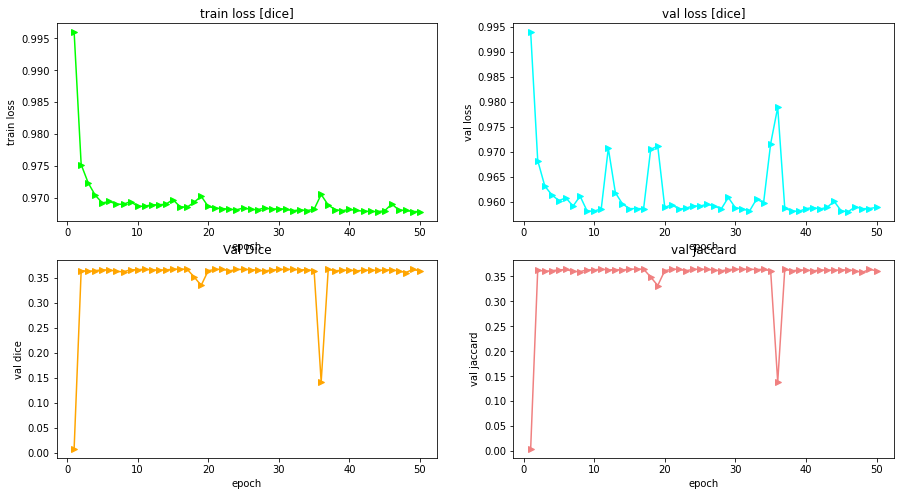

In [23]:
history = defaultdict(list)
best_val_dice = -float('inf')
best_val_jaccard = -float('inf')
start = time.time()

scheduler = get_scheduler(optimizer)

for epoch in range(CONFIG["NUM_EPOCHS"]):
    
    print(f'{sr_}===================== Epoch: [{epoch+1}/{CONFIG["NUM_EPOCHS"]}] =====================')

    # train and validation loop
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, epoch+1, scheduler)
    val_loss, val_scores = valid_one_epoch(model, test_loader,CONFIG["DEVICE"], epoch+1)
    val_dice, val_jaccard = val_scores
    
    
    # save model
    model_file = save_model(model, optimizer, loss_fn, epoch+1)
    
    
    # weight and baise Log the metrics
    wandb.log({"Train Loss": train_loss})
    wandb.log({"Valid Loss": val_loss})
    wandb.log({"Valid dice": val_dice})
    wandb.log({"Valid jaccard": val_jaccard})

    # logging
    history["epoch"].append(epoch+1)
    history['Train_Loss'].append(train_loss)
    history['Valid_Loss'].append(val_loss)
    history['Valid_jaccard'].append(val_jaccard)
    history['Valid_dice'].append(val_dice)
    history["model_file"].append(model_file)

    
    # print loss and scores
    print(f"\n Final Train Loss: {train_loss:0.4f}  |  Final Val Loss: {val_loss:0.4f}") 
    
    print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
    
    
    # print best val score
    if best_val_dice < val_dice:
        print(f"{b_}val dice increased: {best_val_dice} ---> {val_dice}")
        best_val_dice = val_dice
    
    if best_val_jaccard < val_jaccard:
        print(f"{b_}val jaccard increased: {best_val_jaccard} ---> {val_jaccard}")
        best_val_jaccard = val_jaccard

        
        
# print time
end = time.time()
time_elapsed = end - start
avg_time_per_epoch = time_elapsed/CONFIG["NUM_EPOCHS"] 
summary_df = pd.DataFrame.from_dict(history)

print(f'\n ====================== [Training Summary] ====================== \n')
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

print('avg time per [train + val] epoch {:.0f}h {:.0f}m {:.0f}s'.format(
    avg_time_per_epoch // 3600, (avg_time_per_epoch % 3600) // 60, (avg_time_per_epoch % 3600) % 60))

print("Best: ~~~~~~ dice: {:.4f}  || jaccard {:.4f} || val_loss {:.4f} || train_loss {:.4f} ~~~~~~".format(
    best_val_dice, best_val_jaccard, min(history['Valid_Loss']), min(history['Train_Loss'])))


summary_df.to_csv('training_summary.csv')
print("Saved training summary...")

print(f'\n =============================================================== \n')

display(summary_df)

# plotting training and validation loss
plt.figure(figsize=(15,8))

fig1 = plt.subplot(2,2,1)
fig1.plot(history['epoch'], history['Train_Loss'], color='lime', marker='>')
fig1.set_title("train loss [dice]")
fig1.set(xlabel='epoch', ylabel='train loss')

fig2 = plt.subplot(2,2,2)
fig2.plot(history['epoch'], history['Valid_Loss'], color='cyan',  marker='>')
fig2.set_title("val loss [dice]")
fig2.set(xlabel='epoch', ylabel='val loss')

fig3 = plt.subplot(2,2,3)
fig3.plot(history['epoch'], history['Valid_dice'], color='orange',  marker='>')
fig3.set_title("Val Dice")
fig3.set(xlabel='epoch', ylabel='val dice')

fig4 = plt.subplot(2,2,4)
fig4.plot(history['epoch'], history['Valid_jaccard'], color='lightcoral',  marker='>')
fig4.set_title("val jaccard")
fig4.set(xlabel='epoch', ylabel='val jaccard')

plt.show();

# Inference:

In [24]:
# import numpy as np
# from PIL import Image

# def tile_image(p_img, folder, size: int = 768) -> list:
#     w = h = size
#     im = np.array(Image.open(p_img))
#     # https://stackoverflow.com/a/47581978/4521646
#     tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
#     idxs = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
#     name, _ = os.path.splitext(os.path.basename(p_img))
#     files = []
#     for k, tile in enumerate(tiles):
#         if tile.shape[:2] != (h, w):
#             tile_ = tile
#             tile = np.zeros_like(tiles[0])
#             tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
#         p_img = os.path.join(folder, f"{name}_{k:02}.png")
#         Image.fromarray(tile).save(p_img)
#         files.append(p_img)
#     return files, idxs


In [25]:
# !mkdir -p /kaggle/temp/images

In [26]:
# !mkdir -p frozen_packages
# !cp ../input/starter-flash-semantic-segmentation/frozen_packages/* frozen_packages/
# !cp ../input/ftus-segm-eda-viewer/frozen_packages/* frozen_packages/
# !pip install -q 'kaggle-image-segmentation' --no-index --find-links frozen_packages/

In [27]:
# from scipy.ndimage import binary_opening
# from skimage.morphology import disk
# from kaggle_imsegm.mask import rle_encode


# DATASET_FOLDER = "/kaggle/input/hubmap-organ-segmentation"
# df_test = pd.read_csv("../input/hubmap-organ-segmentation/test.csv")
# TILE_SIZE = 1024

# preds = []
# for _, row in df_test.iterrows():
# #     print(row["pixel_size"])
#     scale = row["pixel_size"] / 0.4
#     test_img = os.path.join(DATASET_FOLDER, "test_images", f"{row['id']}.tiff")
#     im = plt.imread(test_img)
    
#     # perform scaling on level tiles as the input is scaled to the CNN input size anyway
    
#     tiles_img, idxs = tile_image(test_img, "/kaggle/temp/images", size=int(TILE_SIZE / scale))
# #     print(idxs)
#     pred_list = []
#     for img_file in tiles_img:
#         img_org = plt.imread(img_file)
        
#         transformed = test_transform(image=img_org)
#         img = transformed["image"]
#         img = img.reshape((1, *img.shape))
#         img = img.to(CONFIG["DEVICE"])
        
#         output = model(img)
#         output = nn.Sigmoid()(output)
#         msks = (output>0.5).to(torch.uint8).cpu().detach().numpy()
        
#         msks = msks.reshape((msks.shape[2], msks.shape[3]))
#         msks = cv2.resize(msks, (img_org.shape[0:2]), interpolation = cv2.INTER_AREA) #cv2.resize(msks,(*img_org.shape))
# #         print("msks--->", msks.shape)
        
#         pred_list.append(msks)
    
    
#     seg = np.zeros(im.shape[:2], dtype=np.uint8)
#     for tile, (i1, i2, j1, j2) in zip(pred_list, idxs):
#         i2 = min(i2, im.shape[0])
#         j2 = min(j2, im.shape[1])
# #         print('tile',np.array(tile, dtype=np.uint8)[:(i2 - i1), :(j2 - j1)].shape)
# #         print(seg[i1:i2, j1:j2].shape)
#         seg[i1:i2, j1:j2] = np.array(tile, dtype=np.uint8)[:(i2 - i1), :(j2 - j1)]
#     # seg = resize(seg * 255, img.shape[:2], order=0) / 255
#     seg = (seg >= 1).astype(np.uint8)  # binary mask
#     seg = binary_opening(seg, structure=disk(6)).astype(np.uint8)
    
    
#     rle = rle_encode(seg.T) if np.sum(seg) > 1 else {}
#     name, _ = os.path.splitext(os.path.basename(test_img))
#     preds.append({"id": row['id'], "rle": rle.get(1, "")})
    
# df_pred = pd.DataFrame(preds)
# display(df_pred[df_pred["rle"] != ""].head())

In [28]:
# df_ssub = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
# del df_ssub['rle']
# df_pred = df_ssub.merge(df_pred, on='id')

# df_pred[['id', 'rle']].to_csv("submission.csv", index=False)

# !head submission.csv

In [29]:
# print(seg.shape)
# plt.imshow(seg)

# Model File Check:

In [30]:
!ls -la ./model_weights

total 11587424
drwxr-xr-x 2 root root      4096 Jul 31 08:51 .
drwxr-xr-x 4 root root      4096 Jul 31 08:51 ..
-rw-r--r-- 1 root root 237306273 Jul 31 06:12 Vanilla_Unet-0.0001-No-1-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 06:40 Vanilla_Unet-0.0001-No-10-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 06:43 Vanilla_Unet-0.0001-No-11-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 06:47 Vanilla_Unet-0.0001-No-12-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 06:50 Vanilla_Unet-0.0001-No-13-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 06:53 Vanilla_Unet-0.0001-No-14-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 06:56 Vanilla_Unet-0.0001-No-15-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 06:59 Vanilla_Unet-0.0001-No-16-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 07:02 Vanilla_Unet-0.0001-No-17-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 07:06 Vanilla_Unet-0.0001-No-18-8.pth
-rw-r--r-- 1 root root 237306273 Jul 31 07:09 Vanilla_Unet-0.0001-No-19-8.pth
-rw-r--r-- 1 root root 23730627